In [6]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
import math
import time
import importlib
import os
import argparse
import copy
import datetime
import random
import sys
import json

import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
from torchvision import models
import torch.multiprocessing as mp
from torchvision import transforms

# My libs
from core.utils import Stack, ToTorchFormatTensor
import xarray as xr

In [7]:
def get_ssh_gt():
    dataset_path = '../datasets/'
    ref_path = dataset_path + 'ref.nc'
    xgt = xr.open_dataset(ref_path)
    gt = xgt['ssh'].values
    gt = gt[:,5:197,5:197]
    
    maxx = gt.max()
    minn = gt.min()
    transformed_ssh = (gt-minn)/(maxx-minn) # à revoir
    # transformed_ssh =  transformed_ssh[..., np.newaxis]
    transformed_ssh = np.stack((transformed_ssh,)*3, axis=1)

    # ssh_frames = [Image.fromarray(cv2.cvtColor(transformed_ssh[i], cv2.COLOR_BGR2RGB)) for i in range(len(transformed_ssh))]
    
    return torch.tensor(transformed_ssh), [transformed_ssh[i].transpose(1,2,0)*255 for i in range(len(transformed_ssh))],(maxx,minn)

In [8]:
ground_truth, frames, scale = get_ssh_gt()
#tensor of normalized frames, list of frames normalized * 255, min max scale  

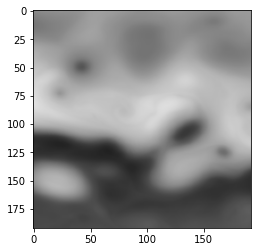

In [9]:
plt.imshow(frames[0].astype(int))

In [11]:
ckpt = 'checkpoints/sttn.pth'
model = 'sttn'

In [12]:
# set up models 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = importlib.import_module('model.' + model)
model = net.InpaintGenerator().to(device)
model_path = ckpt
data = torch.load(ckpt, map_location=device)
model.load_state_dict(data['netG'])
print('loading from: {}'.format(ckpt))
model.eval()

loading from: checkpoints/sttn.pth


InpaintGenerator(
  (transformer): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadedAttention(
        (query_embedding): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (value_embedding): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (key_embedding): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (output_linear): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (attention): Attention()
      )
      (feed_forward): FeedForward(
        (conv): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
    )
    (1): TransformerBlock(
     